In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
import sys
sys.path.append('..')
from dataset import batcher

In [30]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [48]:
# Get test split
# bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS']
bands = ['BLUE', 'GREEN', 'RED', 'DELTA_TEMP']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=652).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 4)


In [49]:
# Load model
experiments = ['imagery_sample_vgg_regression_RGB+DELTA_TEMP']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [50]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-18 14:55:15.556777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 1.41972274e-01]
 [-5.23356378e-01]
 [-4.96515214e-01]
 [ 1.36067712e+00]
 [-4.49434698e-01]
 [-5.63079536e-01]
 [-2.06650347e-01]
 [ 1.10707164e-01]
 [ 1.36067712e+00]
 [-4.97619987e-01]
 [-5.26365578e-01]
 [-1.73824519e-01]
 [-4.55593675e-01]
 [ 5.85151911e-02]
 [ 1.90220803e-01]
 [ 2.66791046e-01]
 [-4.12182987e-01]
 [ 5.85151911e-02]
 [ 6.20612442e-01]
 [ 3.01957309e-01]
 [-2.99460697e-03]
 [ 2.26280347e-01]
 [ 2.87045300e-01]
 [ 3.24944437e-01]
 [ 3.21678579e-01]
 [ 2.12209746e-01]
 [ 1.27318347e+00]
 [-4.10813093e-01]
 [-4.96001720e-01]
 [ 4.17628765e-01]
 [ 5.01187027e-01]
 [-6.07512414e-01]
 [ 6.03000689e+00]
 [-5.52634180e-01]
 [ 2.68560082e-01]
 [ 3.41058195e-01]
 [-4.06380773e-01]
 [-1.35452524e-01]
 [ 1.44396603e+00]
 [-5.34074381e-02]
 [ 8.14258695e-01]
 [ 4.34705764e-01]
 [-4.26375568e-01]
 [-2.11717352e-01]
 [-4.19276685e-01]
 [ 5.76344550e-01]
 [-4.90523994e-01]
 [-4.18256104e-01]
 [ 4.52062130e-01]
 [ 3.32666636e-01]
 [ 4.24117148e-01]
 [ 4.37474847e-02]
 [ 1.4439660

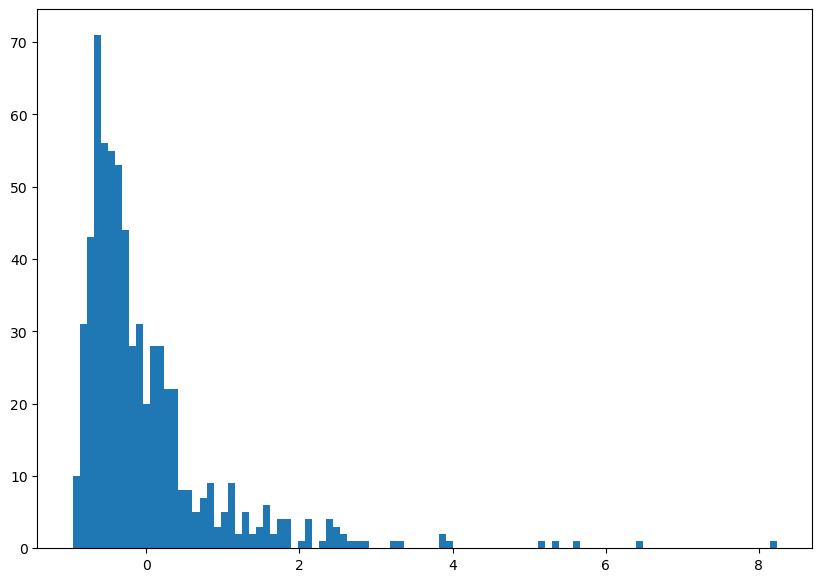

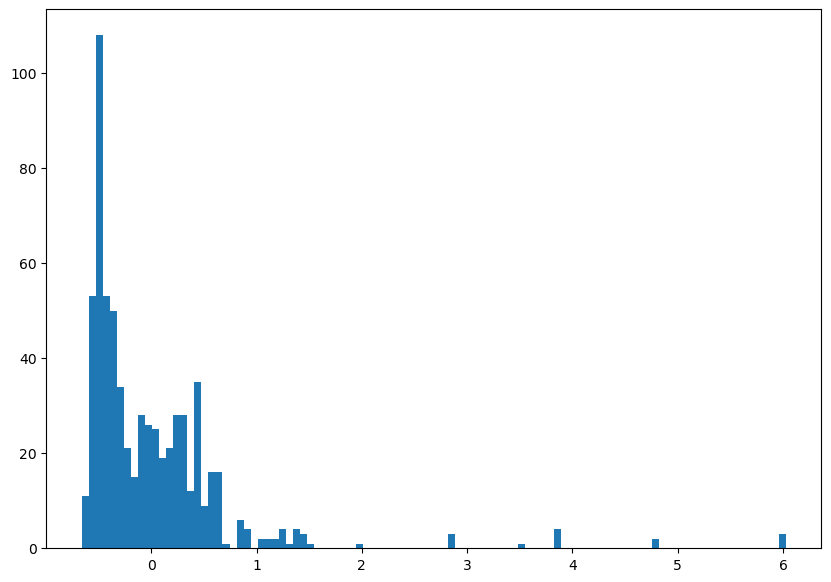

In [51]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

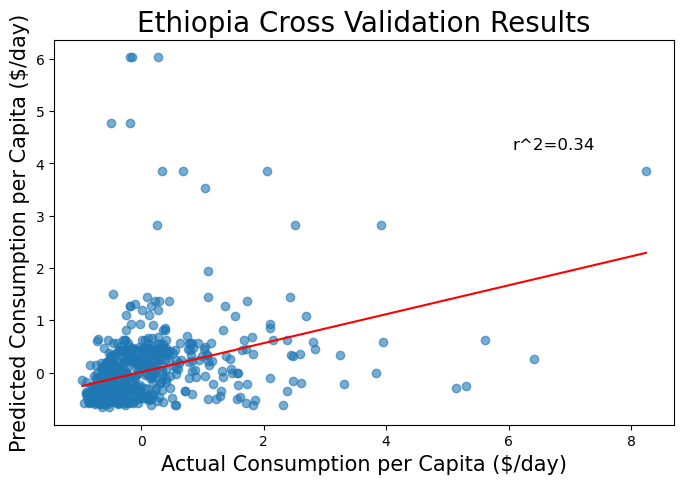

In [52]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()